# Informe final de la carrera


Profundiza y ajusta la resolución de tus proyectos. Agrega una fuente de datos, prueba un modelo nuevo o responde una pregunta nueva. Elabora un informe final que describa el proceso de toma de decisiones. Sustenta la razón por la cual usaste las librerías y aplicaste los métodos al dataset. Todos tus hallazgos deberán ser comunicados en función de la problemática y las preguntas que buscabas responder.

Punto de partida: Proyecto 2

Como informe final voy a retomar el proyecto 2 y tratar de mejorar su rendimiento aplicando Xgboost. 

In [1]:
#imporamos las librerias con las que vamos a trabajar en la parte A
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures

*Importo el Datset y realizo un filtro sobre propiedad, trabajando sólo con departamento, PH y casa de Capital Federal; la superficie total debe ser mayor a la cubierta y debe tener como máximo 5 baños. El valor máximo a tomar por propiedad es de hasta USD$400.000*

In [2]:
proyecto = pd.read_csv('DS_Proyecto_01_Datos_Properati.csv') #importamos el dataset 
proyecto.head(2)

,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,property_type,operation_type
0,2019-10-17,2019-12-23,2019-10-17,-34.605880,-58.384949,Argentina,Capital Federal,San Cristobal,7.0,7.0,2.0,140.0,140.0,153000.0,USD,"***Venta semipiso centro, ideal hostel*****",DESCRIPCION DE LA PROPIEDAD: Departamento de 1...,Departamento,Venta
1,2019-10-17,2019-11-21,2019-10-17,-34.624056,-58.412110,Argentina,Capital Federal,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,USD,Espectacular PH reciclado en Boedo sin expensas.,PH reciclado en Boedo a una cuadra de la plaz...,PH,Venta


In [3]:
nprop = proyecto.property_type.isin(['Departamento', 'Casa', 'PH'])
nsup=(proyecto['surface_total']>=proyecto['surface_covered'])
nprecio= proyecto['price']<=400000
ncap= proyecto['l2']=='Capital Federal'
nban= proyecto['bathrooms']<=5


proyecto=proyecto[nprop & nsup & nprecio & ncap & nban]
proyecto.shape


(70059, 19)

**Encoding**

In [4]:
dummies= pd.get_dummies(proyecto['property_type'], prefix = 'property_type')
dummies

,property_type_Casa,property_type_Departamento,property_type_PH
0,0,1,0
1,0,0,1
2,0,0,1
3,0,0,1
5,0,0,1
...,...,...,...
146542,0,1,0
146543,0,1,0
146545,0,1,0
146549,0,0,1


**Concatenamos**

In [5]:
concatenado_uno =pd.concat([proyecto,dummies], axis=1)
concatenado_uno.head(2)

,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,bedrooms,...,surface_covered,price,currency,title,description,property_type,operation_type,property_type_Casa,property_type_Departamento,property_type_PH
0,2019-10-17,2019-12-23,2019-10-17,-34.605880,-58.384949,Argentina,Capital Federal,San Cristobal,7.0,7.0,...,140.0,153000.0,USD,"***Venta semipiso centro, ideal hostel*****",DESCRIPCION DE LA PROPIEDAD: Departamento de 1...,Departamento,Venta,0,1,0
1,2019-10-17,2019-11-21,2019-10-17,-34.624056,-58.412110,Argentina,Capital Federal,Boedo,2.0,1.0,...,58.0,159000.0,USD,Espectacular PH reciclado en Boedo sin expensas.,PH reciclado en Boedo a una cuadra de la plaz...,PH,Venta,0,0,1


**Elimino variables que no utilizo**

In [6]:
proyecto_uno = concatenado_uno.drop(columns = ['start_date', 'end_date', 'lat', 'lon', 'currency','title', 'description', 'operation_type', 'l1', 'created_on', 'property_type', 'l2','l3'])
proyecto_uno.head(2)

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type_Casa,property_type_Departamento,property_type_PH
0,7.0,7.0,2.0,140.0,140.0,153000.0,0,1,0
1,2.0,1.0,2.0,70.0,58.0,159000.0,0,0,1


**Detección de outliers**

In [7]:
from scipy.stats import zscore

zscore_precio = zscore(proyecto_uno['price'])
zscore_suptot = zscore(proyecto_uno['surface_total'])
zscore_supcub = zscore(proyecto_uno['surface_covered'])
filtro_zscore = (abs(zscore_precio)>3) |  (abs(zscore_suptot)>3) | (abs(zscore_supcub)>3)
proyecto_dos= proyecto_uno[~filtro_zscore]

In [8]:
proyecto_dos.shape

(69947, 9)

**Escalado de Datos**

Definimos X e Y y escalamos los datos

In [9]:
X = proyecto_dos[['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'property_type_Casa', 'property_type_Departamento', 'property_type_PH']] 
y = proyecto_dos['price']

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
scl = StandardScaler()
X_train_scaler = scl.fit_transform(X_train)
X_train_scaler

array([[ 0.18695917,  0.16741775,  1.04521618, ..., -0.13591919,
         0.41271085, -0.38210247],
       [ 0.18695917,  0.16741775,  1.04521618, ..., -0.13591919,
         0.41271085, -0.38210247],
       [ 0.18695917,  0.16741775, -0.59468742, ..., -0.13591919,
         0.41271085, -0.38210247],
       ...,
       [-0.70980699, -0.89305258,  1.04521618, ..., -0.13591919,
         0.41271085, -0.38210247],
       [ 1.08372532,  1.22788808, -0.59468742, ..., -0.13591919,
        -2.42300391,  2.61709905],
       [-1.60657315, -0.89305258, -0.59468742, ..., -0.13591919,
         0.41271085, -0.38210247]])

In [12]:
np.mean(X_train_scaler),np.std(X_train_scaler) #media y desviacion estandar

(4.2284384618209225e-17, 1.0)

In [13]:
X_test_scaler = scl.transform(X_test)
X_test_scaler

array([[ 0.18695917,  0.16741775,  1.04521618, ..., -0.13591919,
         0.41271085, -0.38210247],
       [ 0.18695917,  0.16741775, -0.59468742, ..., -0.13591919,
         0.41271085, -0.38210247],
       [ 1.08372532,  1.22788808, -0.59468742, ..., -0.13591919,
         0.41271085, -0.38210247],
       ...,
       [ 1.08372532,  1.22788808,  1.04521618, ..., -0.13591919,
        -2.42300391,  2.61709905],
       [-0.70980699, -0.89305258, -0.59468742, ..., -0.13591919,
         0.41271085, -0.38210247],
       [ 0.18695917,  0.16741775,  2.68511978, ..., -0.13591919,
         0.41271085, -0.38210247]])

## Árboles de decisión

In [14]:
X_train_dt = X_train_scaler
X_test_dt = X_test_scaler
y_train_dt =y_train
y_test_dt =y_test

tree = DecisionTreeRegressor(max_depth =3) #La profundidad del árbol es 3
tree.fit (X_train_dt,y_train_dt)

y_train_dt_pred = tree.predict(X_train_dt)
y_test_dt_pred =tree.predict(X_test_dt)

rmse_train_dt =np.sqrt(mean_squared_error(y_train_dt, y_train_dt_pred))
rmse_test_dt =np.sqrt(mean_squared_error(y_test_dt, y_test_dt_pred))
print(f'La raíz de error medio cuadrático en Train es:{rmse_train_dt} ')
print(f'La raíz de error medio cuadrático en Test es:{rmse_test_dt} ')

La raíz de error medio cuadrático en Train es:52024.0074955207 
La raíz de error medio cuadrático en Test es:51884.378233808966 


**Modelos Avanzados**

Vamos a utilizar Grid Search, Random Forest y XGBoost

Redefinimos nuevamente las variables


In [15]:
def entrena_modelo (X_train, X_test, y_train, y_test, modelo):
    
    #Entrenamos el modelo y predecimos y_train e y_test:
    modelo.fit(X_train, y_train)
    y_train_pred = modelo.predict(X_train)
    y_test_pred = modelo.predict(X_test)
    
    #Imprimimos las metricas consideradas para evaluar el modelo:
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    r2 = modelo.score(X_test, y_test)
    print(f'Score de modelo: {r2}')
    print(f'Raiz del error cuadrático medio en Train: {rmse_train}')
    print(f'Raiz del error cuadrático medio en Test: {rmse_test}')
    
    #Graficamos la distribucion de errores:
    plt.figure(figsize = (15,6))
    plt.subplot(1,2,1)
    sns.distplot(y_train - y_train_pred, bins = 20, label = 'train')
    sns.distplot(y_test - y_test_pred, bins = 20, label = 'test')
    plt.xlabel('errores')
    plt.legend()

    ax = plt.subplot(1,2,2)
    plt.scatter(y_test,y_test_pred, s =2)    
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
    ]    
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('y (test)')
    plt.ylabel('y_pred (test)')
    
    plt.tight_layout()
    plt.show()
    

    return rmse_train,rmse_test,r2

**GridSearch**

In [16]:
n_estimators = [100,250,500]
max_depth = [10,15,30]


grid= {'n_estimators': n_estimators,
               'max_depth': max_depth,}

In [17]:
modelo5 = GridSearchCV(RandomForestRegressor(random_state = 42),param_grid = grid, n_jobs = -1, cv = 3)

Score de modelo: 0.7680901102277771
Raiz del error cuadrático medio en Train: 30814.74248179693
Raiz del error cuadrático medio en Test: 39727.57570764538


C:\Users\Juli\miniconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Juli\miniconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


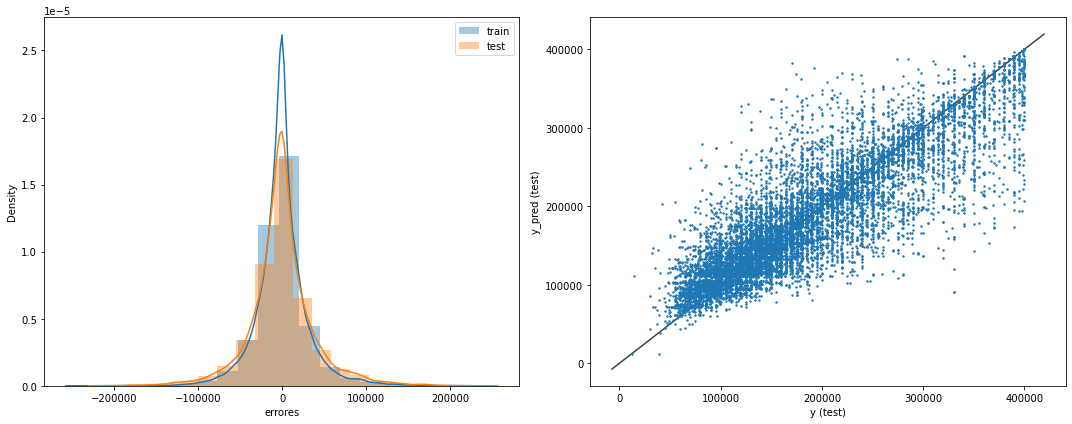

In [18]:
rmse_train_5,rmse_test_5,score5 = entrena_modelo(X_train, X_test, y_train, y_test, modelo5)

**XGBoost con polynomial Features**

In [20]:
poly = PolynomialFeatures(degree = 3, include_bias=False) 
X_train_new = poly.fit_transform(X_train_scaler)
X_test_new = poly.transform(X_test_scaler)

In [21]:
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
XGBRegressor()

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)

In [22]:
eta = [0,1]
max_depth = [10,15,20]



In [23]:
grid= {'learning_rate': eta,
               'max_depth': max_depth,}

In [24]:
modelxgb = GridSearchCV(XGBRegressor(random_state=42), param_grid =grid, n_jobs = 1)

Score de modelo: 0.7305917353855572
Raiz del error cuadrático medio en Train: 29738.22498585858
Raiz del error cuadrático medio en Test: 42819.134670681524


C:\Users\Juli\miniconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Juli\miniconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


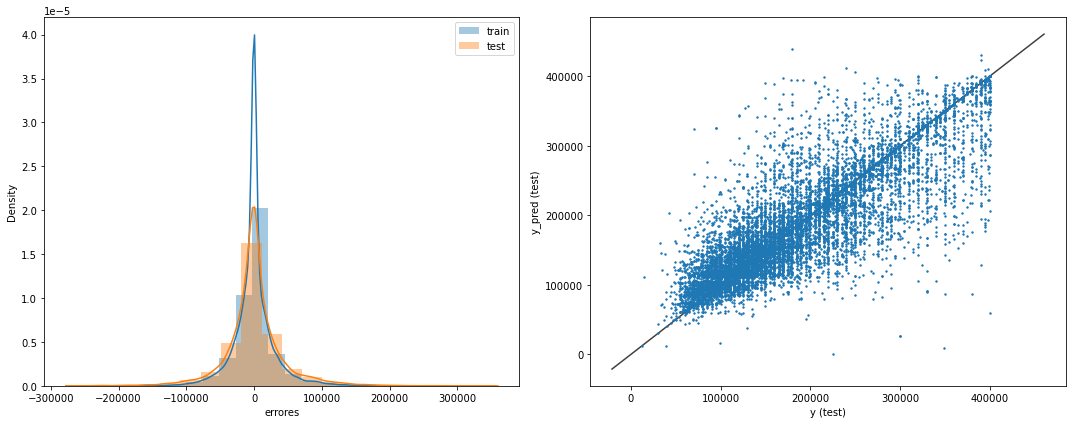

In [26]:
mse_train_5,rmse_test_5,score5 = entrena_modelo(X_train_new, X_test_new, y_train, y_test, modelxgb)

In [27]:
best_params =  modelxgb.best_params_
print (f'Los mejores parametros son: {best_params}')

Los mejores parametros son: {'learning_rate': 1, 'max_depth': 20}


**Features importances** 

In [28]:
modelo5.best_estimator_.feature_importances_

array([0.02312405, 0.02347048, 0.04742426, 0.47397342, 0.40658024,
       0.00159058, 0.01608017, 0.0077568 ])

In [29]:
 X_train.columns

Index(['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered',
       'property_type_Casa', 'property_type_Departamento', 'property_type_PH'],
      dtype='object')

In [32]:
modelxgb.best_estimator_.coef_

AttributeError: Coefficients are not defined for Booster type None

Esperaba que xgboost clasificara mejor que random forest. me sorprende

Hay mucho overfitting en Xgboost. Funcionaria bastante mal con datos nuevos
